In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# CAMEROON: ACLED Data Analysis

Conflicts in Cameroon from January 2010 through July 2021 compiled by ACLED.

## Conflict Mapping

This first section displays ACLED data in mapped form. An interactive version of these graphs and maps can be viewed in ArcGIS.

### A Continental View of Conflict

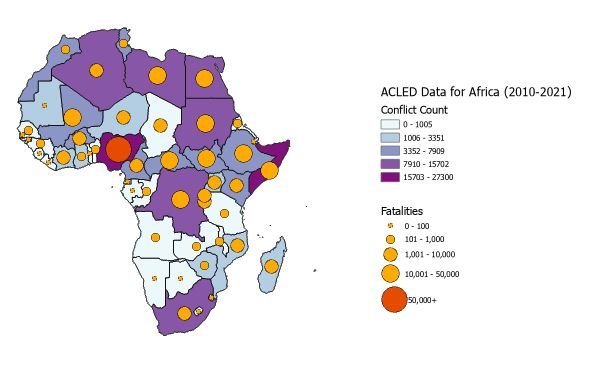

### Zooming in on Cameroon

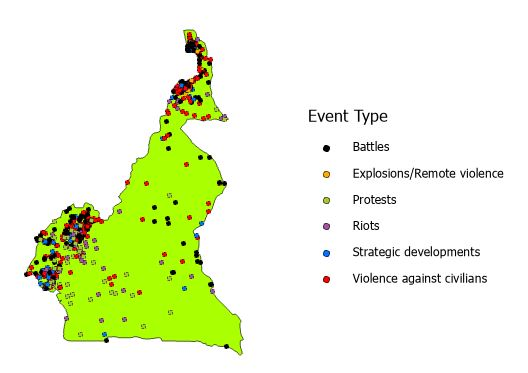

### Conflict in Cameroon by Region

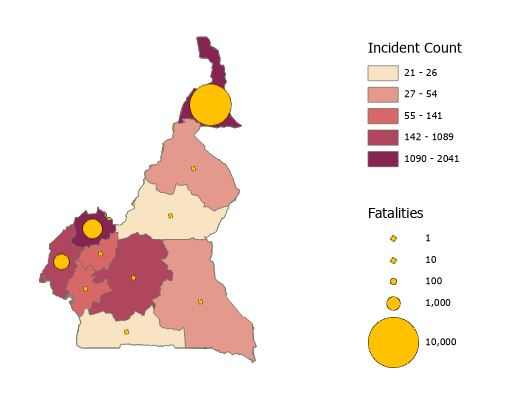

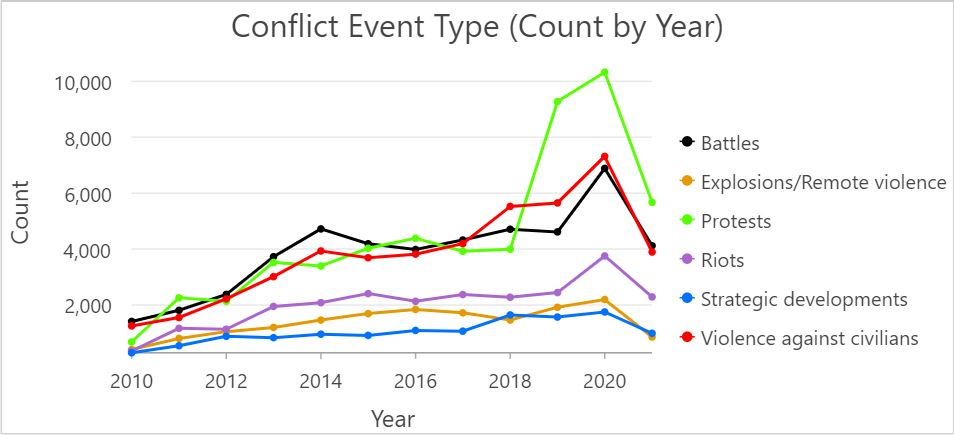

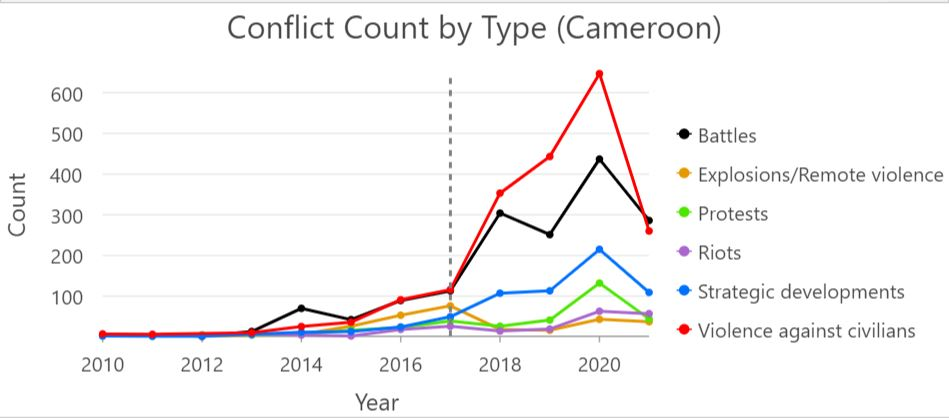

## NLP Analysis

This next section uses Natural Language Processing (NLP) to analyze ACLED's reports on each conflict incident.
Word frequency counts are presented for both the whole time period (2010-2021) and by year.

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')  # load spaCy's built-in English models
import numpy as np
import pandas as pd
import re
from collections import Counter
import plotly.express as px


In [3]:
## extract conflict notes for Cameroon
PATH = r'C:\Users\Zurdo\Documents\Rangel\Summer Internship\SI 2021\INR\Conflict'

df = pd.read_csv(PATH+r'\ACLED_Jan012010_Jul202021_selected.csv',encoding='latin-1')
## filter Cameroon 
is_cam = df['country'] == 'Cameroon'

df_cam = df[is_cam]
df_cam = df_cam.to_numpy()
#print(df_cam.shape) #5088 x 12

corpus = []
years = []
for row in df_cam:
    year = row[1]
    text = row[9]
    if type(text) == str:  #filter out 'float' type instances as will affect nlp process
        years.append(year)
        corpus.append(text)

In [103]:
#first 11 terms added after running code once
stop_words = ['size','report','protest','their','over','around','during','after','area','use','between','the','to','in','rt','of','a', 'for','and','is','on','amp','you','i','at','will','our','we','be','with','that','it','this','are','https','s','have','by','from','has','all','as','not','was','out','t','your','my','who','her','me','he','about','so','make','just','w','she','they','us','his','if','up','again','an','what','one','no','here','but','can','last','than','were','do','would','been','am','http','had','when','made','them','or','there','another','youre']


histogram = Counter()
for text in corpus:
    parsed_text = nlp(text)
    for token in parsed_text:
            lemma = token.lemma_
            lemma = lemma.lower()
            if re.match('[a-zA-Z]+$', lemma):
                histogram[lemma] += 1
                
from operator import itemgetter
sorted_lemma_count_pairs = sorted(histogram.items(),
                                  reverse=True,
                                  key=itemgetter(1))

filtered_sorted_lemma_count_pairs = [(lemma, count)
                                     for lemma, count in sorted_lemma_count_pairs
                                     if lemma not in stop_words]

# for lemma, count in filtered_sorted_lemma_count_pairs[:50]:
#     print(lemma, ":", count)

In [104]:
lemmas = []
counts = []

for lemma, count in filtered_sorted_lemma_count_pairs[:15]:
    lemmas.append(lemma)
    counts.append(count)

fig = px.bar(x=lemmas, y=counts,
                 labels=dict(x="Word", y="Frequency"),title = "Cameroon Conflicts Word Freq (2010-2021)")
fig.update_xaxes(tickfont=dict(family='Rockwell', size=11),tickangle=45)
fig.show()

## Word Frequency by Year

Notice that "boko" and "haram" are the most common terms during 2014-2017 but by 2018 those are replaced by terms like "seperatist" and "ambazonian".

Also notice that the amount of conflict incidents in Cameroon jump significantly after 2017.

In [105]:
df = pd.read_csv(PATH+r'\ACLED_Jan012010_Jul202021_selected.csv',encoding='latin-1')
## filter Cameroon 
is_cam = df['country'] == 'Cameroon'

df_cam = df[is_cam]

#capture incident count by year
incident_count = []

year_list = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]

for year in year_list:
    is_year = df_cam['year'] == year
    df_year = df_cam[is_year]
    tot_incidents = len(df_year)
    incident_count.append(tot_incidents)
    df_year = df_year.to_numpy()
    corpus = []
    for row in df_year:
        text = row[9]
        if type(text) == str:  #filter out 'float' type instances as will affect nlp process
            corpus.append(text)
    histogram = Counter()
    for text in corpus:
        parsed_text = nlp(text)
        for token in parsed_text:
                lemma = token.lemma_
                lemma = lemma.lower()
                if re.match('[a-zA-Z]+$', lemma):
                    histogram[lemma] += 1

    from operator import itemgetter
    sorted_lemma_count_pairs = sorted(histogram.items(),
                                      reverse=True,
                                      key=itemgetter(1))

    filtered_sorted_lemma_count_pairs = [(lemma, count)
                                         for lemma, count in sorted_lemma_count_pairs
                                         if lemma not in stop_words]

#     for lemma, count in filtered_sorted_lemma_count_pairs[:50]:
#         print(lemma, ":", count)
    
    lemmas = []
    counts = []

    for lemma, count in filtered_sorted_lemma_count_pairs[:15]:
        lemmas.append(lemma)
        counts.append(count)
        
    fig = px.bar(x=lemmas, y=counts,
                 labels=dict(x="Word", y="Frequency"),title = "Cameroon Protests Word Freq in %d. Total incidents = %d" % (year, tot_incidents),
                 width=900, height=300)
    fig.update_xaxes(tickfont=dict(family='Rockwell', size=11),tickangle=45)
    fig.show()
    

In [106]:
fig = px.line(x=year_list[:-1], y=incident_count[:-1],
                     labels=dict(x="Year", y="Incident Count"),title = "Cameroon Conflict Incident Counts (by Year)")
fig.update_xaxes(tickfont=dict(family='Rockwell', size=11),tickangle=45)
fig.add_vline(x=2017,line_dash="dash", line_color="red")
fig.show()

## Topic Modeling using LDA

`min_df`: ignore terms that have a document frequency strictly lower than the given threshold

`max_df`: ignore terms that have a document frequency strictly higher than the given threshold

In [68]:
#vocab_size = 1000
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or that are stop words

# document frequency (df) means number of documents a word appears in
tf_vectorizer = CountVectorizer(max_df=0.95,
                                min_df=.1,
                                stop_words='english',
#                                max_features=vocab_size)
                               )
tf = tf_vectorizer.fit_transform(corpus)
#tf is 32856 (events) x 53 (words)
# tf.shape

tf= tf.toarray()


In [69]:
# list of words corresponding to each column on matrix above
print(tf_vectorizer.get_feature_names())
print(len(tf_vectorizer.get_feature_names()))

['ambazonian', 'april', 'attacked', 'bamenda', 'boko', 'casualty', 'engaged', 'extreme', 'fatality', 'february', 'fighters', 'fights', 'forces', 'haram', 'injured', 'january', 'killed', 'killing', 'march', 'mayo', 'mezam', 'military', 'nord', 'ouest', 'people', 'report', 'reported', 'sava', 'separatists', 'size', 'subdivision', 'sud', 'suspected', 'town', 'village']
35


## Fit LDA model to data

In [79]:
num_topics = 5

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics)
lda.fit(tf)

# word_topic_matrix = lda.transform(tf)

LatentDirichletAllocation(n_components=5)

In [80]:
# normalize word counts to get probability distributions
print(lda.components_.shape)
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])
print(topic_word_distributions.sum(axis=1)) #verify prob sum adds up to 1


(5, 35)
[1. 1. 1. 1. 1.]


In [81]:
num_top_words = 5

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()

    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 5 words per topic and their probabilities within the topic...

[Topic 0]
extreme : 0.10507611321298928
nord : 0.10240838960852017
boko : 0.09798621141335567
haram : 0.09798621056498479
mayo : 0.09276994921323801

[Topic 1]
ouest : 0.1168575432613209
ambazonian : 0.10977169120114039
separatists : 0.1040983106575646
town : 0.08514734872332162
nord : 0.07516419574868993

[Topic 2]
reported : 0.2933311035403271
fatality : 0.2341427645285583
casualty : 0.23414276426948985
military : 0.041031874376637634
forces : 0.03824838975845624

[Topic 3]
military : 0.1098418400305923
forces : 0.10705822471462945
ouest : 0.10090980089535426
separatists : 0.0718699749514345
subdivision : 0.07064610091621461

[Topic 4]
size : 0.1947487137173012
report : 0.17378793957544048
town : 0.09854845872878054
subdivision : 0.08839020776899098
forces : 0.056918396712487655



In [13]:
# ## peaceful conflict ratio ##
# #PATH = r'C:\Users\Zurdo\Documents\Rangel\Summer Internship\SI 2021\INR\Conflict'
# df = pd.read_csv(PATH+r'\africa_conflict_CountYrType.csv',encoding='utf-8')
# df = df.to_numpy()

# years = [2018,2019,2020]

# PATH = r'C:\Users\Zurdo\Documents\Rangel\Summer Internship\SI 2021\INR'

# with open('african_countries.txt', 'r') as file:

# #file = open('african_countries.txt', 'r')

#     lines = file.readlines()

#     countries = []
#     for line in lines:
#         line = line.lower()
#         line = line.strip()
#         countries.append(line)
# vr_pairs = []
# for year in years:
#     for country in countries:
#         nv_count = 0
#         v_count = 0
#         for row in df:
#             place = row[2]
#             place = place.lower()
#             if year == row[1] and country == place:
#                 if row[0] == "Peaceful protest":
#                     nv_count += row[4]
#                 elif row[0] == "Violent demonstration" or row[0] == "Mob violence":
#                     v_count += row[4]
#         vr_pairs.append([year,country, v_count/(v_count+nv_count+.01)])

# print(vr_pairs)
                    
                    

# ## need to work with 2018-07-09-2021-07-13_Africa_clean.csv to count event frequencies by year ##
